# Predicitng household dislocation, Seaside, OR.
based on the earthquake and tsunami damage to the buildings and socio-economic characteristics of households
## Modules

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE)
BACKCOLOR = '#f6f5f5'
from IPython.core.display import HTML

## User Modules

In [146]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [147]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines[['top', 'right']].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [148]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=data, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines[['top','right']].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

-------------------------------------------------------------------------------
## Read Data

In [149]:
all_data = pd.read_csv('population_raw.csv', delimiter=',', index_col=None).dropna(axis=1, how='all')

-------------------------------------------------------------------------------
# EDA

## 1. Check Data

In [150]:
all_data.head(5).style.background_gradient()

,guid,DS_0,DS_1,DS_2,DS_3,hazard,addrptid,struct_typ,year_built,no_stories,appr_bldg,dgn_lvl,str_typ2,FID_NEW,origin,stat_class,rmv_improv,rmv_land,elev,period,strctid,blockid,x,y,huestimate,residential,randomap,randommergeorder,blockidstr,huid,livetype,numprec,ownershp,race,hispan,vacancy,gqtype,bgid,randomhu,aphumerge,geometry,Race Ethnicity,Tenure Status,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated,return period
0,37532fb5-5107-478b-ab2c-158eb001c68b,0.934466,0.059929,0.005274,0.000332,Earthquake+Tsunami,41007020864002001S001001A,W1,1975,1,13415,Low - Code,W1,5692,1,192,0,0,-9.132547,0.350000,41007020864002001S,410080000000000.000000,-123.903427,46.017498,1.000000,1.000000,0.041695,1,B410079507001001,B410079507001001H073,H,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,410080000000.000000,0.015908,both,POINT (-123.9034265041881 46.01749849919388),"1 White alone, Not Hispanic",1 Owner Occupied,0.000000,23.540150,1,0.002914,0.100425,0.524702,0.889881,0.235623,1,100
1,e38d8575-7880-4a8c-b6d7-225ab1cf9264,0.924142,0.069944,0.005395,0.000519,Earthquake+Tsunami,41007021038001001S001001A,RC,0,1,80970,Pre - Code,RC,5633,1,499,0,80970,-13.312578,0.400000,41007021038001001S,410080000000000.000000,-123.896065,46.012722,1.000000,1.000000,0.324219,2,B410079507001001,B410079507001001H064,H,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,410080000000.000000,0.016828,both,POINT (-123.8960661064165 46.01272230816045),"1 White alone, Not Hispanic",1 Owner Occupied,0.000000,23.540150,1,0.006930,0.132025,0.677548,0.951019,0.239481,0,100
2,66d39314-1c68-4634-a82c-8fcb37f529ff,0.967514,0.030488,0.001944,0.000054,Earthquake+Tsunami,41007020956001001S001001A,W1,1979,1,338531,Low - Code,W1,5580,1,131,91412,247119,-14.807998,0.350000,41007020956001001S,410080000000000.000000,-123.900246,46.013523,1.000000,1.000000,0.508544,3,B410079507001001,B410079507001001H083,H,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,410080000000.000000,0.022826,both,POINT (-123.9002451964179 46.01352343272472),"1 White alone, Not Hispanic",1 Owner Occupied,0.000000,23.540150,1,0.005776,0.100000,0.654935,0.941974,0.234538,0,100
3,af5771b4-4f42-4166-b772-78a3706fa8ac,0.982265,0.017250,0.000370,0.000115,Earthquake+Tsunami,41007020864002002S001001A,W1,2003,1,117979,Moderate - Code,W1,12,1,192,12424,105555,-9.132547,0.350000,41007020864002002S,410080000000000.000000,-123.903427,46.017498,1.000000,1.000000,0.753476,4,B410079507001001,B410079507001001H080,H,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,410080000000.000000,0.033113,both,POINT (-123.9034265041881 46.01749849919388),"1 White alone, Not Hispanic",1 Owner Occupied,0.000000,23.540150,1,0.002404,0.105851,0.436479,0.854591,0.231936,0,100
4,8f6e055b-2df8-461b-80a0-ba0c1f65add5,0.982265,0.017250,0.000370,0.000115,Earthquake+Tsunami,41007021172001001S001001A,W1,2002,1,220791,Moderate - Code,W1,269,1,140,135339,85452,-13.774883,0.350000,41007021172001001S,410080000000000.000000,-123.897186,46.012028,1.000000,1.000000,0.056960,1,B410079507001005,B410079507001005H010,H,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,410080000000.000000,0.076698,both,POINT (-123.8971825599634 46.01202832179288),"1 White alone, Not Hispanic",1 Owner Occupied,0.000000,23.540150,1,0.003029,0.133077,0.438777,0.855511,0.232445,1,100


In [151]:
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

total size : 27920 x 53


-------------------------------------------------------------------------------
## 2. Description
I start the EDA with checking the description of each column to understand the input data generally. 

| Column | Definition |
|:-|:-|
| guid    | A unique id for each buidling |
| DS_0 to DS_3| Probability of being in each damages states where DS_0 = No damage and DS_4 = Complete damage|
| hazard | Hazard type (Earthquake+Tsunami for all data points in this case)|
| addrptid | Address point ID |
| struct_typ| Type of structural system |
| year_built | Constructiuon time |
| no_stories | Number of stories of the building |
| appr_bldg | Building value ($)|
| dgn_lvl | Building design level |
| str_typ2 | Type of structural system (repetitive) |
| FID_NEW | Building value (repetitive) |
| ... | for complete description look at [the original paper](https://www-tandfonline-com.ezproxy.rice.edu/doi/abs/10.1080/23789689.2019.1681821?journalCode=tsri20)|

In [152]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27920 entries, 0 to 27919
Data columns (total 53 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   guid              27920 non-null  object 
 1   DS_0              27920 non-null  float64
 2   DS_1              27920 non-null  float64
 3   DS_2              27920 non-null  float64
 4   DS_3              27920 non-null  float64
 5   hazard            27920 non-null  object 
 6   addrptid          23952 non-null  object 
 7   struct_typ        27920 non-null  object 
 8   year_built        27920 non-null  int64  
 9   no_stories        27920 non-null  int64  
 10  appr_bldg         27920 non-null  int64  
 11  dgn_lvl           27920 non-null  object 
 12  str_typ2          27920 non-null  object 
 13  FID_NEW           27920 non-null  int64  
 14  origin            27920 non-null  int64  
 15  stat_class        27920 non-null  int64  
 16  rmv_improv        27920 non-null  int64 

In [153]:
all_data.isnull().sum()

guid                    0
DS_0                    0
DS_1                    0
DS_2                    0
DS_3                    0
hazard                  0
addrptid             3968
struct_typ              0
year_built              0
no_stories              0
appr_bldg               0
dgn_lvl                 0
str_typ2                0
FID_NEW                 0
origin                  0
stat_class              0
rmv_improv              0
rmv_land                0
elev                    0
period                  0
strctid                 0
blockid              3968
x                    3968
y                    3968
huestimate           3968
residential          3968
randomap                0
randommergeorder        0
blockidstr           8956
huid                 8956
livetype             8956
numprec              8956
ownershp            10576
race                15708
hispan              15708
vacancy              8956
gqtype               8956
bgid                 8956
randomhu    

In [154]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns])

,guid
a698bf89-e06b-4d88-8116-81037737919b,264
6d2093bf-c7d6-437b-8fcd-4a2d24618494,220
9f60823f-be6d-4739-a02c-bba7eae5245b,212
63eb15cd-588e-4cfc-b5b1-212ec6611a3f,212
ebb84a98-c88c-40fd-9289-8d59ec3c8142,184
...,...
0e6a6d62-8592-4dbc-a359-6c76daa3d136,4
97c9a132-39b7-4b5d-82c5-761fc331b597,4
3b858cce-9989-4d19-a61e-ac3e6f14f0bc,4
3290017a-9ef6-4368-84b8-5ea0135b3083,4


### Remove redundant or uninformative columns based on investigation

In [155]:
all_data.drop(['guid', 'addrptid', 'strctid', 'hazard', 'str_typ2', 'blockid', 'residential', 'geometry', 'FID_NEW',
               'bgid', 'aphumerge'], axis=1, inplace=True)

### Seperate continous and nominal columns

In [156]:
continuous_vars = ['DS_0', 'DS_1', 'DS_2', 'DS_3', 'year_built', 'no_stories', 'appr_bldg', 'rmv_improv', 'rmv_land', 
                    'elev', 'period', 'x', 'y', 'huestimate', 'randomap', 'randommergeorder', 'numprec', 'randomhu',
                   'phispbg', 'pblackbg', 'rploss_0', 'rploss_1', 'rploss_2', 'rploss_3', 'prdis', 'return period']
nominal_vars = [x for x in all_data.columns if x not in continuous_vars ]
target = 'dislocated'

In [157]:
all_st = all_data[continuous_vars].describe()
multi_table([all_st])

,DS_0,DS_1,DS_2,DS_3,year_built,no_stories,appr_bldg,rmv_improv,rmv_land,elev,...,numprec,randomhu,phispbg,pblackbg,rploss_0,rploss_1,rploss_2,rploss_3,prdis,return period
count,27920.000000,27920.000000,27920.000000,2.792000e+04,27920.000000,27920.000000,2.792000e+04,2.792000e+04,2.792000e+04,27920.000000,...,18964.000000,18964.000000,18964.000000,18964.000000,27920.000000,27920.000000,27920.000000,27920.000000,18964.000000,27920.000000
mean,0.479682,0.247940,0.112685,1.596938e-01,1949.879656,2.105731,6.861463e+05,4.624444e+05,2.229654e+05,-3.975244,...,1.401603,0.501512,5.087735,0.159465,0.004995,0.153823,0.550398,0.900159,0.460869,462.500000
std,0.318039,0.159743,0.118533,2.756821e-01,187.784107,1.767048,2.008387e+06,1.839707e+06,3.652014e+05,3.721445,...,1.521825,0.290460,4.970909,0.354927,0.001978,0.057922,0.098233,0.039293,0.154822,341.647378
min,0.000004,0.000006,0.000004,1.250000e-07,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-14.997761,...,0.000000,0.000169,0.000000,0.000000,0.000871,0.100000,0.308628,0.803451,0.231936,100.000000
25%,0.233901,0.063058,0.005685,4.050961e-03,1940.000000,1.000000,1.820832e+05,7.633775e+04,6.710350e+04,-4.173621,...,0.000000,0.248332,0.000000,0.000000,0.003547,0.104986,0.476638,0.870655,0.355253,212.500000
50%,0.462668,0.319940,0.093956,3.426674e-02,1973.000000,1.000000,2.670970e+05,1.402760e+05,1.295620e+05,-2.961076,...,1.000000,0.506107,4.475854,0.000000,0.004751,0.129964,0.551422,0.900569,0.416080,375.000000
75%,0.753262,0.376353,0.168557,1.429143e-01,1996.000000,2.000000,4.539580e+05,2.461670e+05,2.218050e+05,-2.071088,...,2.000000,0.756571,8.301158,0.000000,0.006151,0.190114,0.622250,0.928900,0.524562,625.000000
max,0.993170,0.584189,0.542842,9.999857e-01,2203.000000,6.000000,1.901118e+07,1.769744e+07,6.453285e+06,1.690376,...,19.000000,0.999796,23.540150,1.026119,0.015776,0.299983,0.789521,0.995808,0.880136,1000.000000


-------------------------------------------------------------------------------
## 3. Missing Value 
Most variables had missing values. These are subject to preprocessing.  

<AxesSubplot:>

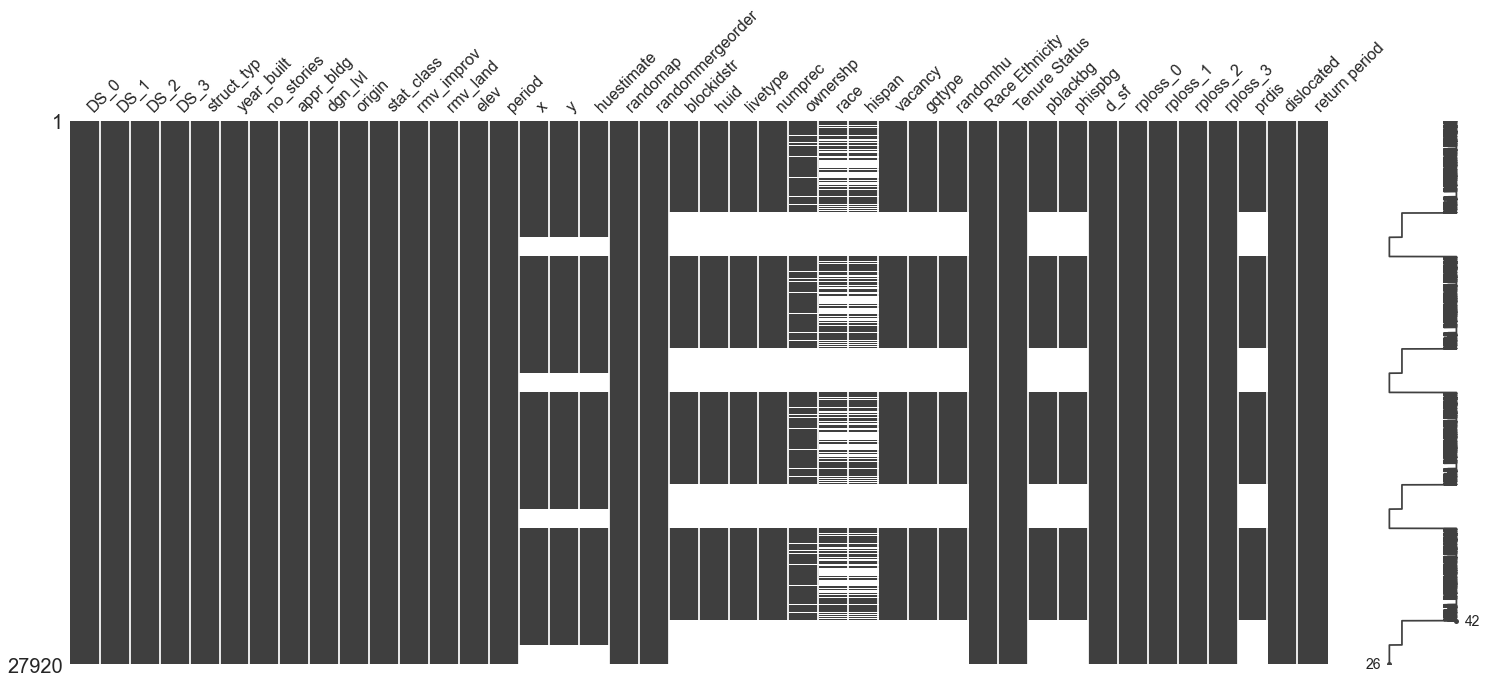

In [158]:
import missingno as msno
msno.matrix(all_data)

<AxesSubplot:>

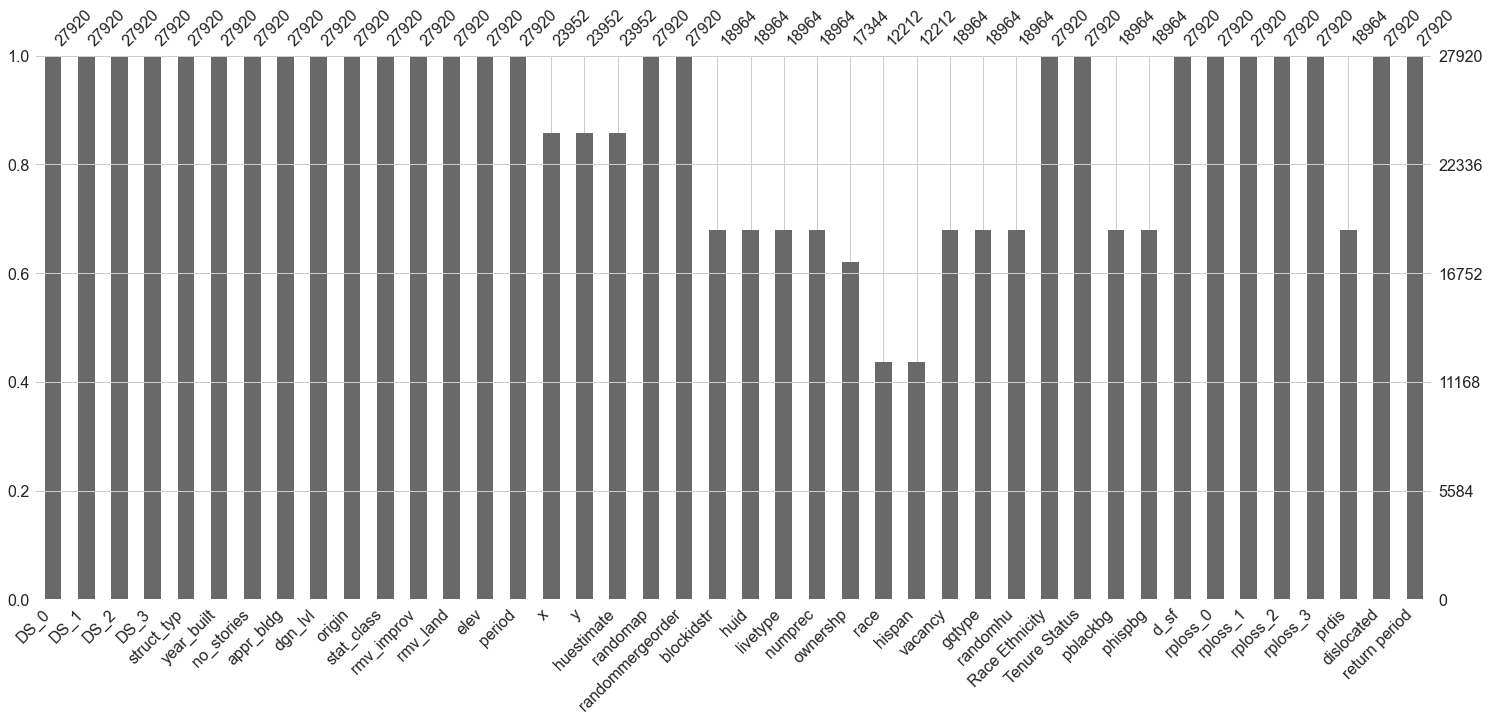

In [159]:
msno.bar(all_data)

<AxesSubplot:>

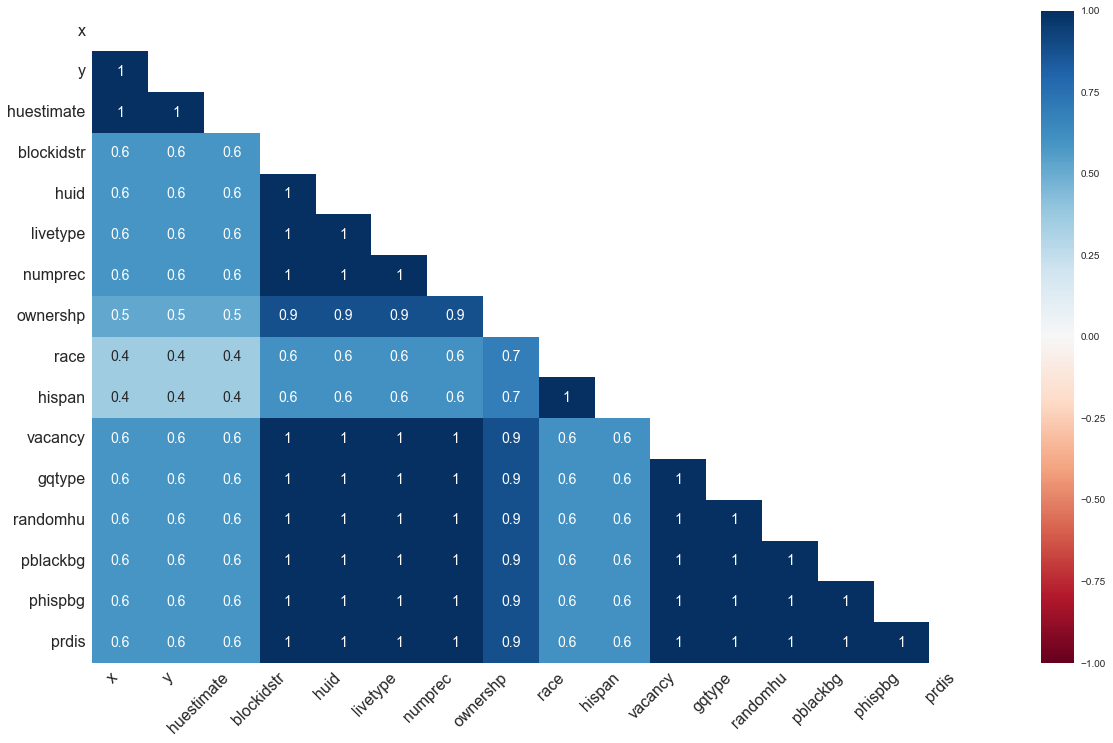

In [160]:
msno.heatmap(all_data)

<AxesSubplot:>

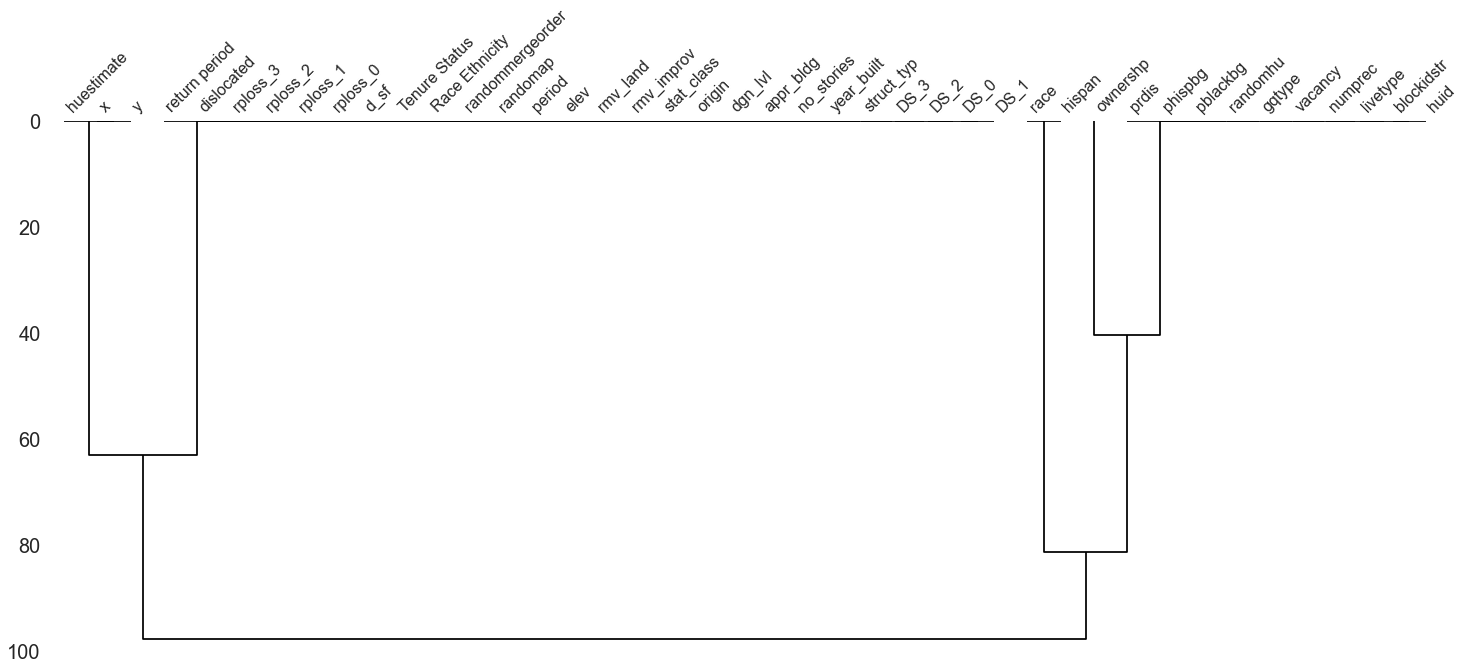

In [161]:
msno.dendrogram(all_data)

### Remove redundant or uninformative columns based on perfect correlations

In [162]:
all_data.drop(['x', 'y', 'blockidstr', 'huid', 'livetype', 'vacancy', 'gqtype', 'randomhu', 'phispbg', 'prdis', 'randommergeorder'], axis=1, inplace=True)

-------------------------------------------------------------------------------
## 4. Detail Explore 
### Seperate test data to avoid data leakage

In [163]:
train, test = train_test_split(all_data, test_size=0.2, random_state=1)
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')

train size : 22336 x 31
test size : 5584 x 31


### Dislocated (Dependent, binary)  

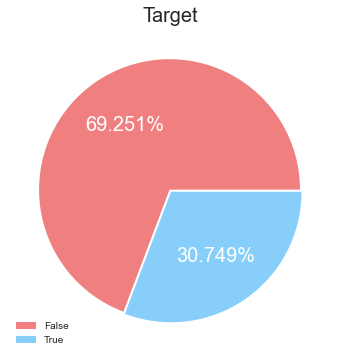

In [164]:
plt.subplots(figsize=(10, 6))
plt.pie(train.dislocated.value_counts(), explode=[.01,.01], autopct='%1.3f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('Target', size=20)
plt.legend(['False', 'True'], loc='best')
plt.show()

-------------------------------------------------------------------------------
### Race (Nominal)

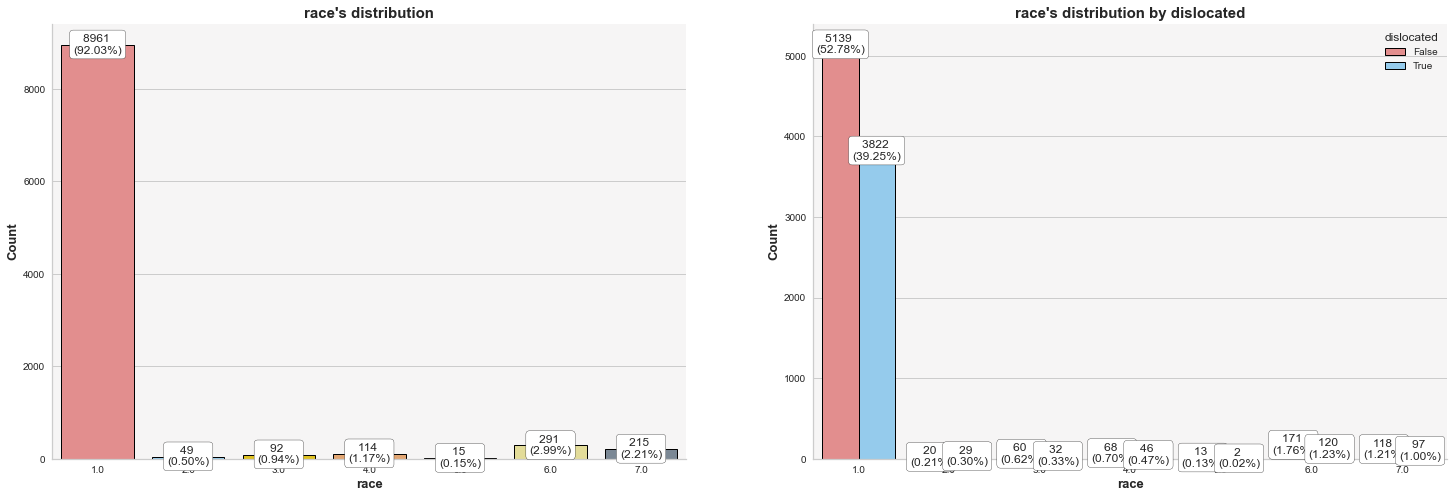

,count,sum,mean
,dislocated,dislocated,dislocated
race,,,
1.000000,8961,3822,0.426515
2.000000,49,29,0.591837
3.000000,92,32,0.347826
4.000000,114,46,0.403509
5.000000,15,2,0.133333
6.000000,291,120,0.412371
7.000000,215,97,0.451163


In [165]:
cat_dist(train, var='race', hue='dislocated')
train.pivot_table(index="race", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
### Ownership (Nominal)  

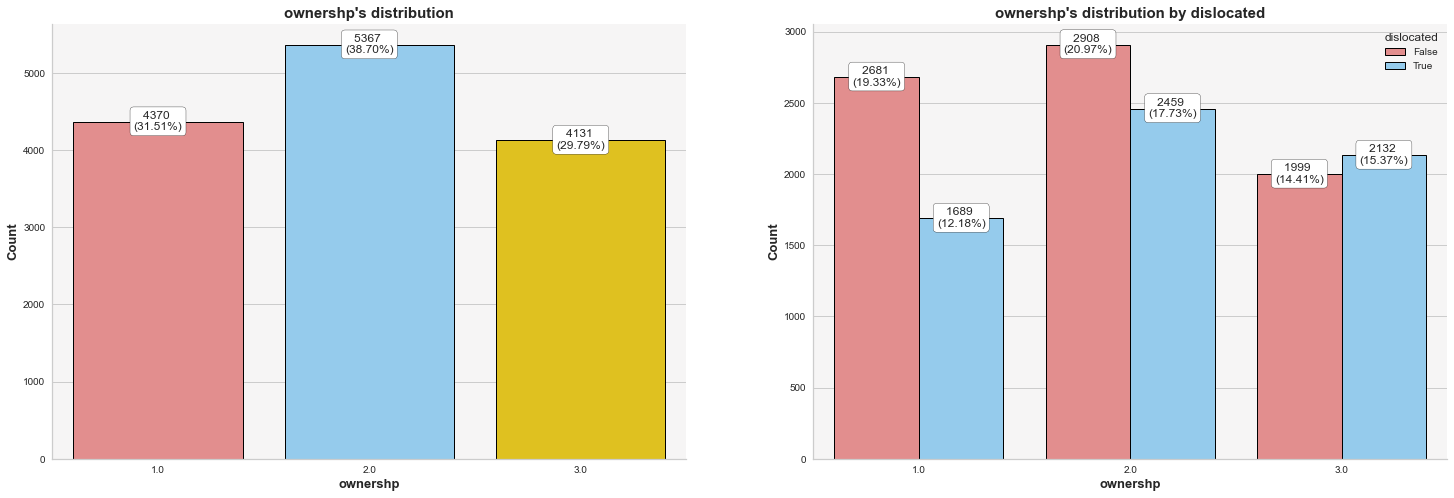

,count,sum,mean
,dislocated,dislocated,dislocated
ownershp,,,
1.000000,4370,1689,0.386499
2.000000,5367,2459,0.458170
3.000000,4131,2132,0.516098


In [166]:
cat_dist(train, var='ownershp', hue='dislocated')
train.pivot_table(index="ownershp", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
### Number of residents

posx and posy should be finite values
posx and posy should be finite values


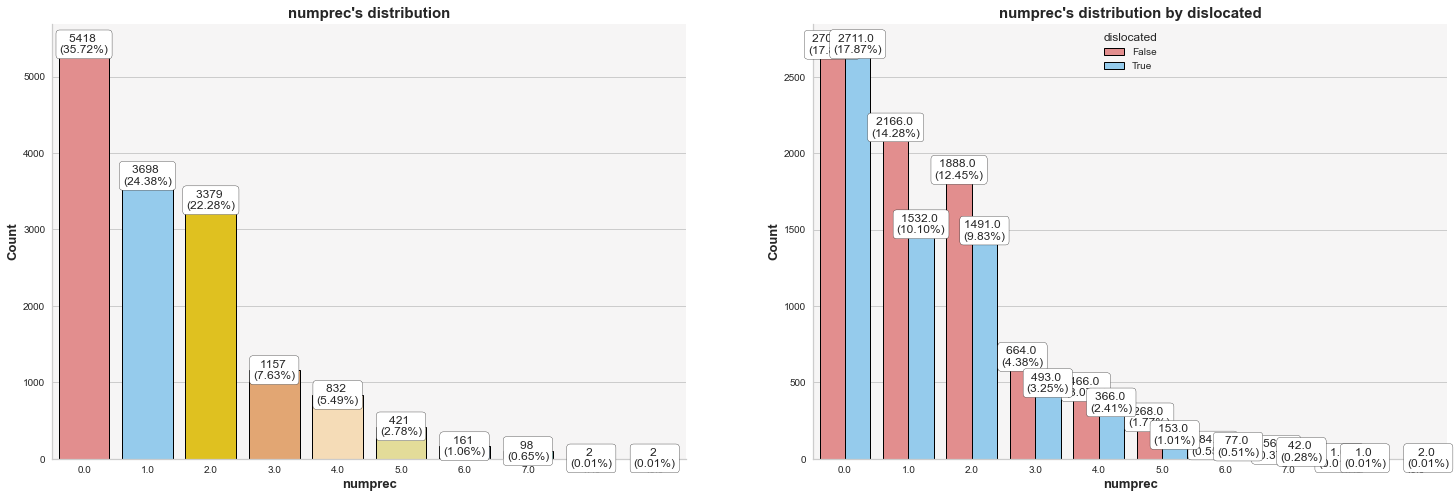

,count,sum,mean
,dislocated,dislocated,dislocated
numprec,,,
0.000000,5418,2711,0.500369
1.000000,3698,1532,0.414278
2.000000,3379,1491,0.441255
3.000000,1157,493,0.426102
4.000000,832,366,0.439904
5.000000,421,153,0.363420
6.000000,161,77,0.478261
7.000000,98,42,0.428571


In [167]:
cat_dist(train, var='numprec', hue='dislocated')
train.pivot_table(index="numprec", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
### Age (continuous)  

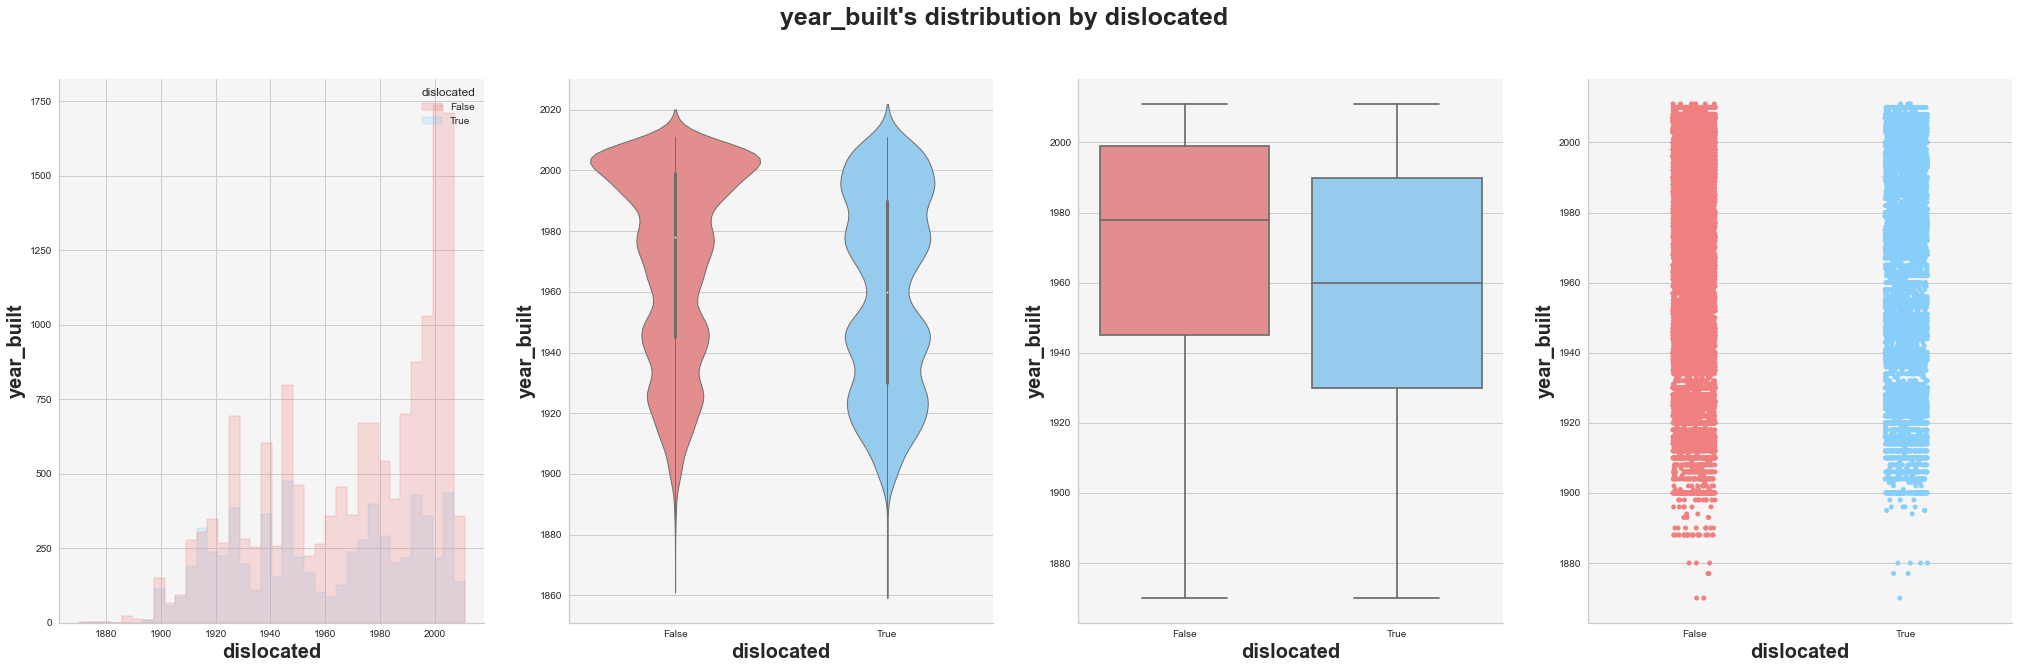

In [168]:
# Some based on the exploration
train.replace([0, 1, 200, 2203], 0, inplace=True)
test.replace([0, 1, 200, 2203], 0, inplace=True)

continuous_dist(train[train['year_built']!=0], 'dislocated', 'year_built')

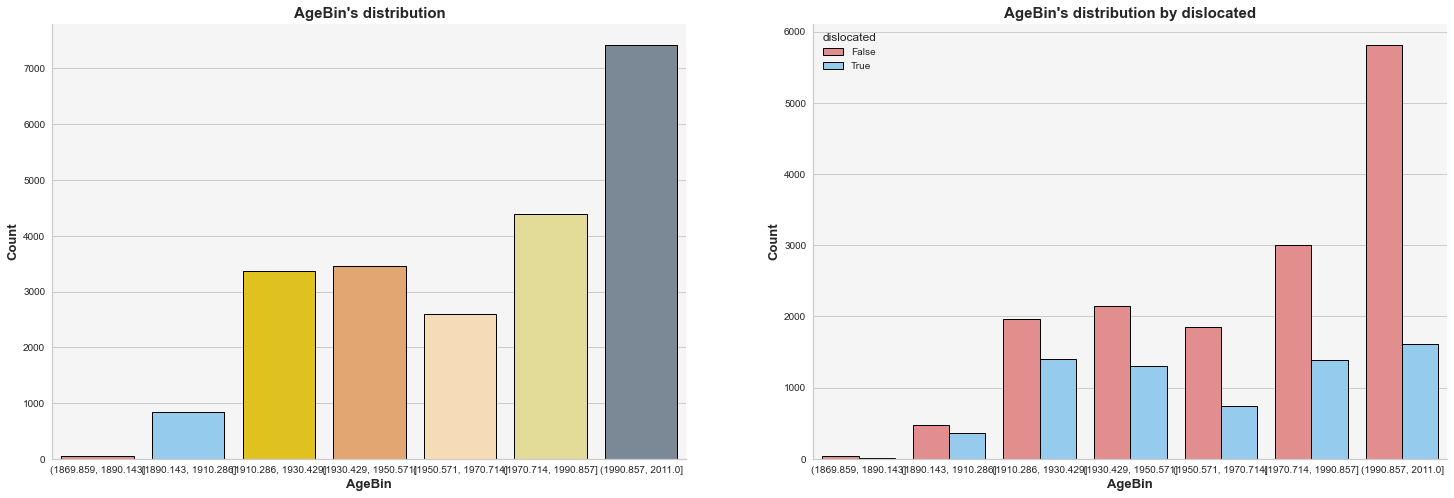

,count,sum,mean
,dislocated,dislocated,dislocated
AgeBin,,,
"(1869.859, 1890.143]",44,7,0.159091
"(1890.143, 1910.286]",846,369,0.436170
"(1910.286, 1930.429]",3369,1403,0.416444
"(1930.429, 1950.571]",3449,1308,0.379240
"(1950.571, 1970.714]",2590,741,0.286100
"(1970.714, 1990.857]",4390,1392,0.317084
"(1990.857, 2011.0]",7427,1611,0.216911


In [169]:
tmp = train.copy()
tmp = tmp[tmp['year_built']!=0]
tmp['AgeBin'] = pd.cut(tmp['year_built'], bins=7)
cat_dist(tmp, var='AgeBin', hue='dislocated', msg_show=False)
tmp.pivot_table(index="AgeBin", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
### Building value (continuous)  

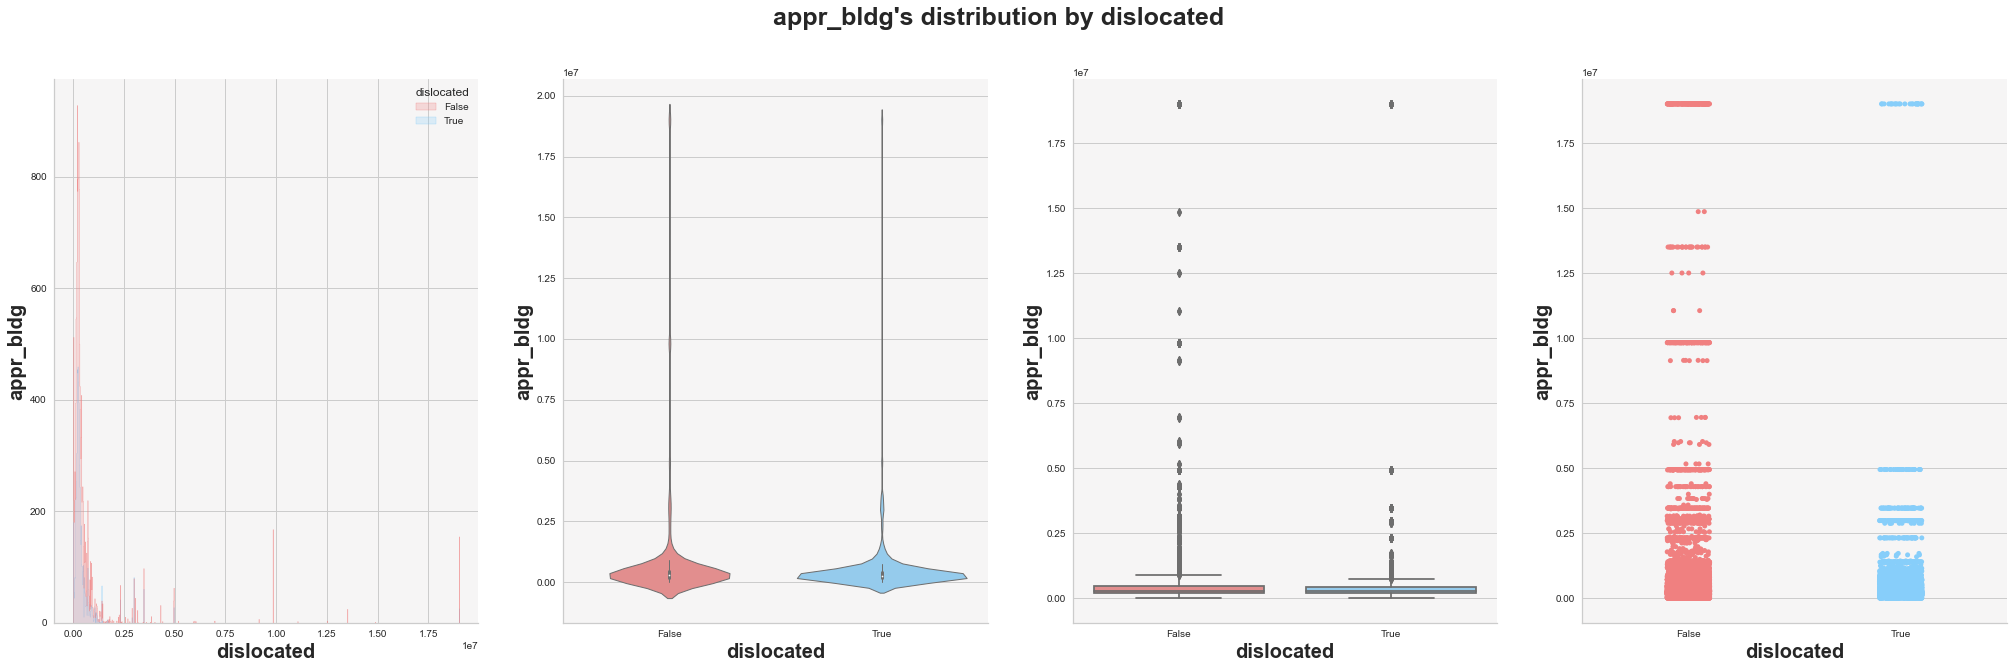

In [170]:
continuous_dist(train[train['appr_bldg']!=0], 'dislocated', 'appr_bldg')

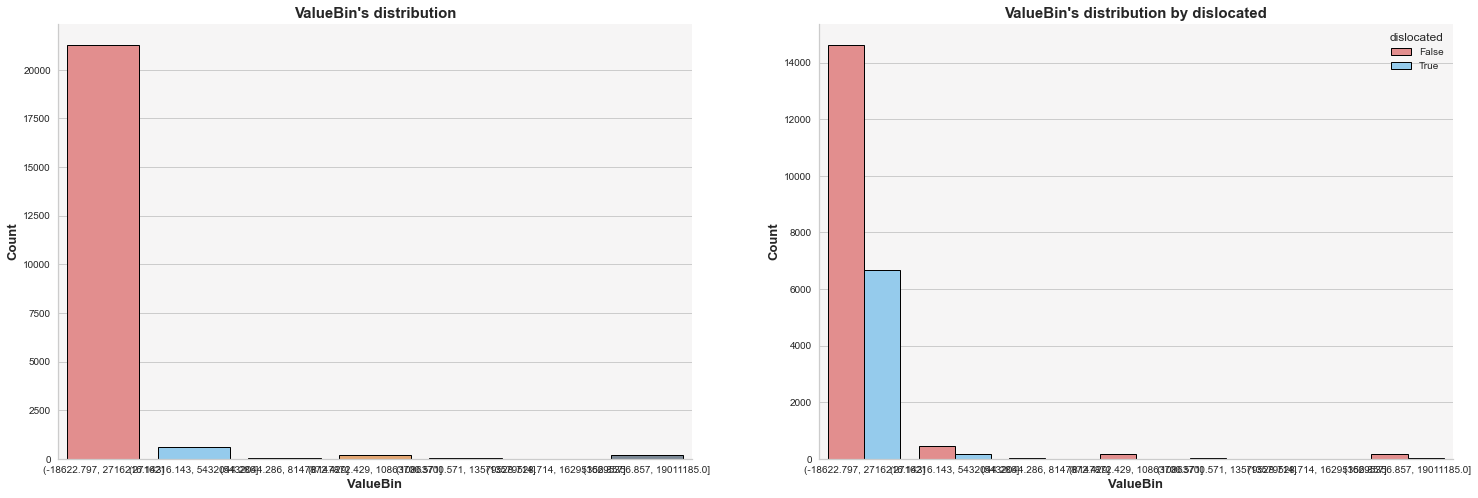

,count,sum,mean
,dislocated,dislocated,dislocated
ValueBin,,,
"(-18622.797, 2716216.143]",21291,6657,0.312667
"(2716216.143, 5432044.286]",620,181,0.291935
"(5432044.286, 8147872.429]",17,0,0.000000
"(8147872.429, 10863700.571]",175,0,0.000000
"(10863700.571, 13579528.714]",32,0,0.000000
"(13579528.714, 16295356.857]",2,0,0.000000
"(16295356.857, 19011185.0]",181,26,0.143646


In [171]:
tmp = train.copy()
tmp = tmp[tmp['appr_bldg']!=0]
tmp['ValueBin'] = pd.cut(tmp['appr_bldg'], bins=7)
cat_dist(tmp, var='ValueBin', hue='dislocated', msg_show=False)
tmp.pivot_table(index="ValueBin", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
### Desgin level (nominal)  

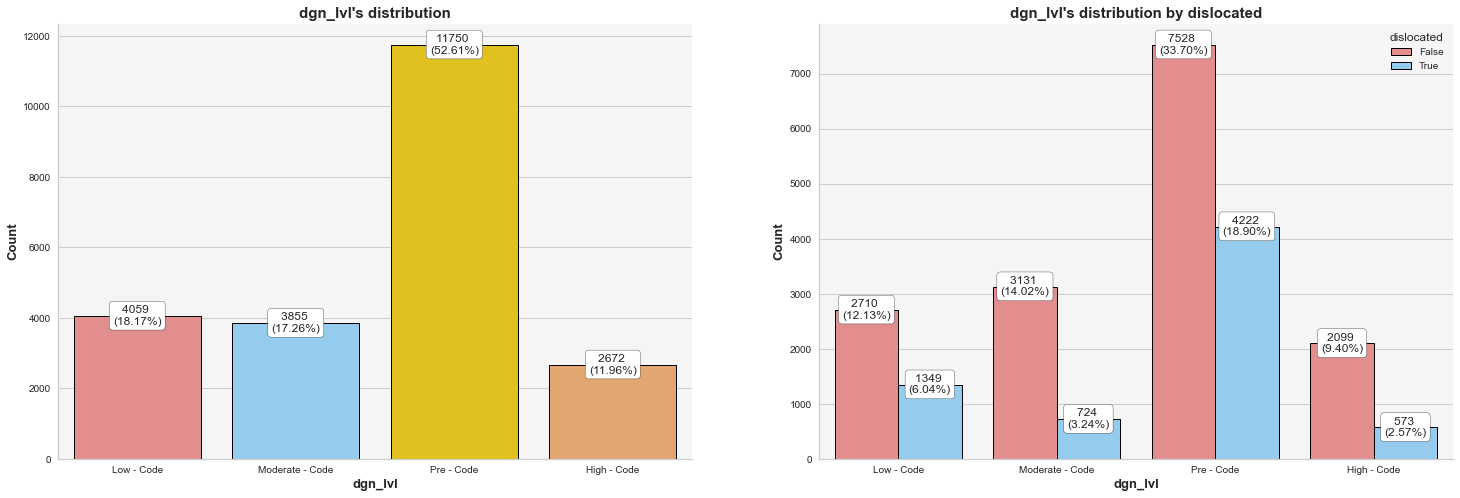

,count,sum,mean
,dislocated,dislocated,dislocated
dgn_lvl,,,
High - Code,2672,573,0.214446
Low - Code,4059,1349,0.332348
Moderate - Code,3855,724,0.187808
Pre - Code,11750,4222,0.359319


In [172]:
cat_dist(train, var='dgn_lvl', hue='dislocated')
train.pivot_table(index="dgn_lvl", values="dislocated", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0)

-------------------------------------------------------------------------------
## 4. Multi-variable Explore  

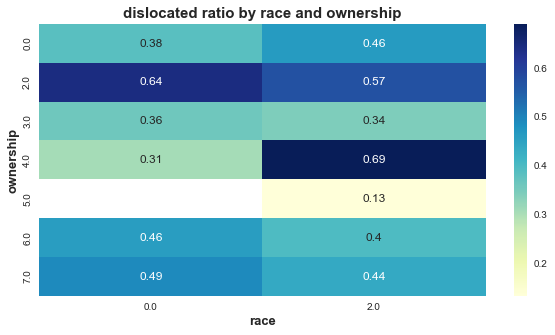

In [173]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='race', columns='ownershp', values='dislocated'), annot=True, cmap="YlGnBu")
g.set_title('dislocated ratio by race and ownership', weight='bold', size=15)
g.set_xlabel('race', weight='bold', size=13)
g.set_ylabel('ownership', weight='bold', size=13)
plt.show()

pd.crosstab([train.race, train.dislocated], train.ownershp,margins=True).style.background_gradient()

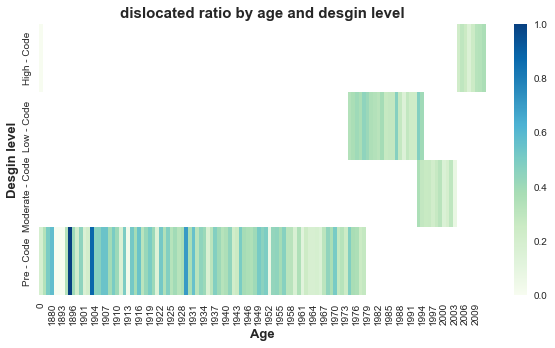

In [174]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='dgn_lvl', columns='year_built', values='dislocated'), annot=False, cmap="GnBu")
g.set_title('dislocated ratio by age and desgin level', weight='bold', size=15)
g.set_xlabel('Age', weight='bold', size=13)
g.set_ylabel('Desgin level', weight='bold', size=13)
plt.show()

# pd.crosstab([train.race, train.dislocated], train.ownershp,margins=True).style.background_gradient()

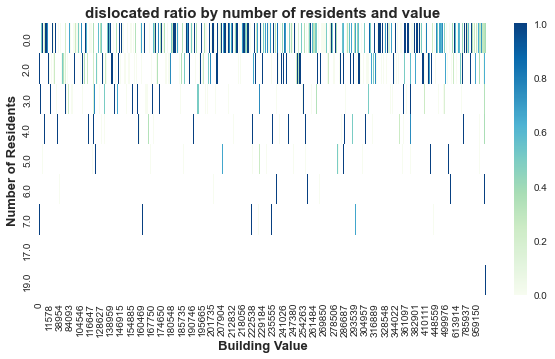

In [175]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='numprec', columns='appr_bldg', values='dislocated'), annot=False, cmap="GnBu")
g.set_title('dislocated ratio by number of residents and value', weight='bold', size=15)
g.set_xlabel('Building Value', weight='bold', size=13)
g.set_ylabel('Number of Residents', weight='bold', size=13)
plt.show()

# pd.crosstab([train.race, train.dislocated], train.ownershp,margins=True).style.background_gradient()

-------------------------------------------------------------------------------
# Preprocessing
### Imputing Missing values

In [176]:
# Replace categorical variables with specific values (False, None) or freeest values.
train['ownershp'].fillna(train.ownershp.mode()[0], inplace=True)
train['race'].fillna(train.race.mode()[0], inplace=True)
train['hispan'].fillna(train.hispan.mode()[0], inplace=True)

test['ownershp'].fillna(train.ownershp.mode()[0], inplace=True)
test['race'].fillna(train.race.mode()[0], inplace=True)
test['hispan'].fillna(train.hispan.mode()[0], inplace=True)

# Replace continuous variables with specific values (0) or averages.
train['huestimate'].fillna(train.huestimate.mean(), inplace=True)
train['numprec'].fillna(train.numprec.mean(), inplace=True)
train['pblackbg'].fillna(0, inplace=True)

test['huestimate'].fillna(train.huestimate.mean(), inplace=True)
test['numprec'].fillna(train.numprec.mean(), inplace=True)
test['pblackbg'].fillna(0, inplace=True)

print('number of missing values left in train data:', sum(train.isnull().sum()))
print('number of missing values left in test data:', sum(test.isnull().sum()))

number of missing values left in train data: 0
number of missing values left in test data: 0


-------------------------------------------------------------------------------
### Create Derivative variable

In [177]:
# Create new variables by dividing age and value groups.
train['AgeBin'], bins = pd.cut(train['year_built'], bins=7, retbins=True)
test['AgeBin'] = pd.cut(test['year_built'], bins=bins)
train['ValueBin'], bins = pd.cut(train['appr_bldg'], bins=7, retbins=True)
test['ValueBin'] = pd.cut(test['appr_bldg'], bins=bins)

-------------------------------------------------------------------------------
### Encoding  

In [178]:
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'dislocated':
        print(col)
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

struct_typ
dgn_lvl
Race Ethnicity
Tenure Status


### Create train and text matrices

In [179]:
X_train, y_train = train.drop(['dislocated'], axis=1), train['dislocated']
X_test, y_test = test.drop(['dislocated'], axis=1), test['dislocated']

-------------------------------------------------------------------------------
# Modeling and Optimizing  
## Set up pycaret model parameters

In [180]:
from pycaret.classification import *
s = setup(data=train, session_id=3, target='dislocated', train_size=0.99, fold_strategy='stratifiedkfold', fold=5,
          fold_shuffle=True, silent=True, ignore_low_variance=True, remove_multicollinearity = True, normalize = True,
          normalize_method = 'robust',)

,Description,Value
0,session_id,3
1,Target,dislocated
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(22336, 33)"
5,Missing Values,0
6,Numeric Features,26
7,Categorical Features,6
8,Ordinal Features,0
9,High Cardinality Features,0


## Compare various classifiers

In [181]:
best = compare_models(n_select=4, sort = 'Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8615,0.9336,0.7301,0.8024,0.7644,0.6667,0.6683,0.8480
catboost,CatBoost Classifier,0.8506,0.9288,0.6803,0.8045,0.7371,0.6338,0.6382,4.0900
lightgbm,Light Gradient Boosting Machine,0.8255,0.9066,0.6096,0.7757,0.6826,0.5647,0.5725,0.2320
rf,Random Forest Classifier,0.8171,0.8936,0.6091,0.7499,0.6719,0.5471,0.5529,0.6340
dt,Decision Tree Classifier,0.7964,0.7621,0.6728,0.6684,0.6706,0.5233,0.5233,0.0840
gbc,Gradient Boosting Classifier,0.7691,0.8431,0.4396,0.6990,0.5397,0.3961,0.4151,1.2640
et,Extra Trees Classifier,0.7636,0.8345,0.5168,0.6449,0.5736,0.4129,0.4178,0.4820
ada,Ada Boost Classifier,0.7545,0.8223,0.3939,0.6744,0.4969,0.3491,0.3714,0.3580
knn,K Neighbors Classifier,0.7514,0.7951,0.5227,0.6130,0.5642,0.3919,0.3944,0.7960
lr,Logistic Regression,0.7254,0.7472,0.3284,0.5990,0.4242,0.2635,0.2841,0.4520


In [182]:
print(best[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=3, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


In [183]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuning

In [184]:
# !pip install scikit-optimize
# !pip install tune-sklearn ray[tune]
# !pip install hpbandster ConfigSpace
import optuna

In [185]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8587,0.9340,0.7239,0.7984,0.7593,0.6597,0.6612
1,0.8659,0.9379,0.7349,0.8118,0.7715,0.6770,0.6786
2,0.8639,0.9326,0.7509,0.7953,0.7725,0.6755,0.6760
3,0.8668,0.9391,0.7408,0.8104,0.7741,0.6799,0.6813
4,0.8523,0.9246,0.6997,0.7962,0.7448,0.6415,0.6442
Mean,0.8615,0.9336,0.7301,0.8024,0.7644,0.6667,0.6683
SD,0.0054,0.0051,0.0175,0.0072,0.0111,0.0144,0.0139


The following code is the process of optimizing the model to a variety of algorithms. I compared them all because they had different access methods and different results.

In [186]:
xgboost1 = tune_model(create_model('xgboost'), choose_better = True, n_iter = 20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8831,0.9548,0.9170,0.7556,0.8285,0.7411,0.7491
1,0.8711,0.9468,0.9068,0.7360,0.8125,0.7159,0.7250
2,0.8772,0.9470,0.9155,0.7443,0.8211,0.7291,0.7382
3,0.8745,0.9511,0.9038,0.7438,0.8160,0.7222,0.7300
4,0.8777,0.9436,0.8957,0.7536,0.8185,0.7273,0.7335
Mean,0.8767,0.9486,0.9078,0.7467,0.8193,0.7271,0.7352
SD,0.0040,0.0039,0.0078,0.0071,0.0054,0.0084,0.0082


In [187]:
xgboost2 = tune_model(create_model('xgboost'), optimize='Accuracy', search_library='scikit-optimize', 
                      search_algorithm='bayesian', choose_better = True, n_iter = 20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8892,0.9512,0.7981,0.8349,0.8161,0.7369,0.7372
1,0.8883,0.9520,0.7952,0.8344,0.8143,0.7345,0.7349
2,0.8915,0.9500,0.8126,0.8310,0.8217,0.7437,0.7438
3,0.8878,0.9532,0.7827,0.8420,0.8113,0.7316,0.7326
4,0.8770,0.9453,0.7584,0.8277,0.7916,0.7045,0.7059
Mean,0.8868,0.9503,0.7894,0.8340,0.8110,0.7302,0.7309
SD,0.0050,0.0027,0.0182,0.0048,0.0103,0.0135,0.0130


In [188]:
# xgboost3 = tune_model(create_model('xgboost'), optimize='Accuracy', search_library='tune-sklearn', 
#                       search_algorithm='bayesian', choose_better = True, n_iter = 20)

In [189]:
# xgboost4 = tune_model(create_model('xgboost'), optimize='Accuracy', search_library='tune-sklearn', 
#                        search_algorithm='hyperopt', choose_better = True, n_iter = 20)

In [190]:
xgboost5 = tune_model(create_model('xgboost'), optimize='Accuracy', search_library='tune-sklearn', 
                       search_algorithm='optuna', choose_better = True, n_iter = 20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6738,0.8553,0.9706,0.4851,0.6469,0.4009,0.4863
1,0.6887,0.8557,0.9662,0.4972,0.6565,0.4211,0.5004
2,0.6737,0.8646,0.9728,0.4850,0.6473,0.4014,0.4877
3,0.6850,0.8613,0.9633,0.4942,0.6532,0.4151,0.4943
4,0.6836,0.8489,0.9545,0.4930,0.6502,0.4108,0.4870
Mean,0.6809,0.8572,0.9655,0.4909,0.6508,0.4099,0.4911
SD,0.0061,0.0054,0.0064,0.0049,0.0036,0.0078,0.0055


In [191]:
xgboost6 = tune_model(create_model('xgboost'), optimize='Accuracy', search_library='optuna', 
                      search_algorithm='tpe', choose_better = True, n_iter = 20)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7072,0.8833,0.9677,0.5130,0.6706,0.4487,0.5230
1,0.7183,0.8766,0.9581,0.5233,0.6769,0.4629,0.5304
2,0.6992,0.8854,0.9750,0.5059,0.6662,0.4387,0.5183
3,0.7162,0.8788,0.9648,0.5212,0.6768,0.4614,0.5318
4,0.7112,0.8707,0.9479,0.5170,0.6691,0.4498,0.5156
Mean,0.7104,0.8790,0.9627,0.5161,0.6719,0.4523,0.5238
SD,0.0068,0.0052,0.0092,0.0062,0.0043,0.0090,0.0064


### <font color='red'>xgboost2 is the best tuned model</font>

-------------------------------------------------------------------------------
## Ensemble  
I've blended the top four algorithms. Performance has not improved significantly.

In [192]:
tuned_best = [tune_model(i) for i in best]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6921,0.6432,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6921,0.6595,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6922,0.6570,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6920,0.6458,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6920,0.6521,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.6921,0.6515,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0001,0.0063,0.0000,0.0000,0.0000,0.0000,0.0000


In [193]:
blender_best = blend_models(estimator_list=tuned_best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8953,0.9530,0.8546,0.8146,0.8341,0.7577,0.7582
1,0.8944,0.9515,0.8671,0.8050,0.8349,0.7575,0.7586
2,0.8937,0.9545,0.8736,0.7996,0.8350,0.7568,0.7584
3,0.8957,0.9558,0.8642,0.8100,0.8362,0.7599,0.7607
4,0.8939,0.9500,0.8488,0.8147,0.8314,0.7540,0.7544
Mean,0.8946,0.9529,0.8617,0.8088,0.8343,0.7572,0.7581
SD,0.0008,0.0021,0.0089,0.0058,0.0016,0.0019,0.0021


## Predicting Test data

In [194]:
from sklearn.metrics import accuracy_score
df_pred = predict_model(xgboost2, X_test)
y_pred = df_pred.loc[:, ['Label']]
print('Test Accuracy:', accuracy_score(y_pred.squeeze().map({'True': True, 'False': False}), y_test))

Test Accuracy: 0.9027578796561605


-------------------------------------------------------------------------------
# Interpreting Model  
Pycaret provides SHAP.

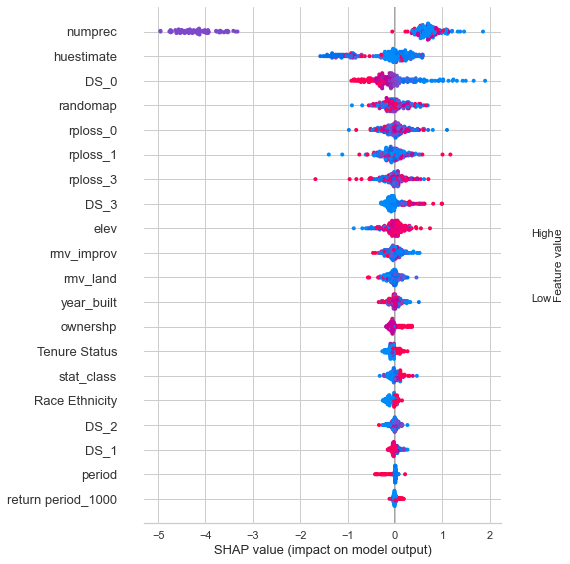

In [195]:
interpret_model(xgboost2)